In [21]:
flex_title = "Dahsboard Transports Genevois"
flex_subtitle = "built using jupyter-flex"
flex_external_link = "https://github.com/benoitfrisque/geneva_transport_analysis"

flex_include_source = True
# flex_orientation = "rows"

# Nombre de montées par arrêt

## Sidebar

In [2]:
import pandas as pd
import numpy as np
import requests

import folium
from folium.plugins import MarkerCluster
from IPython.display import clear_output, display, HTML

# import ipywidgets as widgets
from ipywidgets import widgets, Layout
import plotly.express as px
import plotly.graph_objects as go

from geopy.distance import geodesic

In [3]:
# Define the default start and end dates
slider_start_date = pd.to_datetime('2021-03-01')
slider_end_date = pd.to_datetime('2024-03-31')

slider_dates = pd.date_range(slider_start_date, slider_end_date, freq='MS')
slider_options = [(date.strftime('%B %Y'), date) for date in slider_dates]

# Create a dropdown widget for selecting the month
month_dropdown = widgets.Dropdown(
    options=slider_options,
    index=0
)

month_label = widgets.Label('Sélectionnez un mois :')

# Create a play button widget
play_button = widgets.Play(
    value=0,
    min=0,
    max=len(slider_options) - 1,
    step=1,
    interval=1500,  # Interval in milliseconds
    description="Press play",
    disabled=False
)

# Link the play button to the dropdown index
widgets.jslink((play_button, 'value'), (month_dropdown, 'index'))

# Display widgets
display(widgets.VBox([month_label, month_dropdown, play_button]))

In [4]:
# Load stops

# Option 1 : load stops data from API
def fetch_arrets():
    # API URL for the stops
    base_url = 'https://opendata.tpg.ch/api/explore/v2.1/catalog/'
    endpoint = 'datasets/arrets/records'
    url = base_url + endpoint

    # Query parameters
    offset = 0
    limit = 100
    select = "arretcodelong AS arret_code_long, nomarret as nom_arret, commune, pays, coordonnees, actif"
    where = "" #"actif='Y'"

    all_records = []

    while True:
        params = {
            "limit": limit,
            "offset": offset,
            "select": select,
            "where": where
        }

        # Fetch data from the API endpoint
        response = requests.get(url, params=params)
        response = response.json()

        total_count = response['total_count']
        records = response['results']

        all_records.extend(records)

        # Increment the offset for the next request
        offset += len(records)

        # Break the loop if all records have been fetched
        if offset >= total_count:
        #if offset >=1: # for debugging
            break

    # Convert all_records to a DataFrame
    data_arrets = pd.json_normalize(all_records)
    data_arrets.drop(columns='coordonnees', inplace=True)
    data_arrets.rename(columns={'coordonnees.lon': 'coordonnees_lon', 'coordonnees.lat': 'coordonnees_lat'}, inplace=True)

    data_arrets.fillna(value=np.nan, inplace=True)
    
    return data_arrets


# Option 2 : load stops data from file (faster)
def load_arrets(filepath):
    data_arrets = pd.read_json(filepath)

    # Transform coordinates
    data_arrets["coordonnees_lon"] = data_arrets["coordonnees"].apply(lambda x : x['lon'] if x is not None else None)
    data_arrets["coordonnees_lat"] = data_arrets["coordonnees"].apply(lambda x : x['lat'] if x is not None else None)
    data_arrets.drop(columns='coordonnees', inplace=True)
    data_arrets.rename(columns={'arretcodelong': 'arret_code_long', 'nomarret': 'nom_arret'}, inplace=True)

    data_arrets.fillna(value=np.nan, inplace=True)
    
    return data_arrets


# data_arrets = fetch_arrets()

arrets_filepath = '../data/arrets.json'
data_arrets = load_arrets(arrets_filepath)

data_arrets_actifs = data_arrets[data_arrets['actif'] == 'Y']

## Colonne 1

### Nombre de montées par arrêt (heatmap)

In [5]:
def fetch_nb_montees_par_arret(start_date, end_date):
    # API URL
    base_url = 'https://opendata.tpg.ch/api/explore/v2.1/catalog/'
    endpoint = 'datasets/montees-par-arret-par-ligne/records'
    url = base_url + endpoint

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Query parameters
    offset = 0
    limit = -1
    select = "SUM(nb_de_montees) AS total_nb_de_montees"
    where = f"date >= '{start_date.strftime('%Y-%m-%d')}' AND date <= '{end_date.strftime('%Y-%m-%d')}'"
    group_by = "arret_code_long"
    order_by = "total_nb_de_montees DESC"

    params = {
        "select": select,
        "where": where,
        "group_by": group_by,
        "order_by": order_by,
        "limit": limit,
        "offset": offset,
    }

    # Fetch data from the API endpoint
    response = requests.get(url, params=params)
    response = response.json()

    records = response['results']

    # Convert all_records to a DataFrame
    total_montees_par_arret = pd.json_normalize(records)

    total_montees_par_arret.fillna(value=np.nan, inplace=True)

    return total_montees_par_arret

In [6]:
def plot_heatmap_nb_montees(total_montees_descentes_par_arret, out):
    with out:
        fig = px.density_mapbox(total_montees_descentes_par_arret,
                                lat='coordonnees_lat',
                                lon='coordonnees_lon',
                                z='total_nb_de_montees',
                                range_color=[0, 350e3], # fixed range for the animation
                                hover_name='arret_code_long',
                                hover_data=['nom_arret', 'commune', 'pays'],
                                radius=20,
                                center=dict(lat=46.2044, lon=6.1432),
                                zoom=11,
                                mapbox_style="open-street-map",
                                labels={'nom_arret':'Nom arrêt', 'total_nb_de_montees': 'Total Montees', 'arret_code_long': 'Code Arrêt', 'commune':'Commune', 'pays': 'Pays',
                                       'coordonnees_lon': 'Longitude', 'coordonnees_lat': 'Latitude'}
                               )
        
        fig.update_layout(margin=go.layout.Margin(l=0, r=0, b=0, t=0))
        
        clear_output(wait=True)
        fig.show()


In [7]:
out_heatmap = widgets.Output()
out_heatmap

Output()

## Colonne 2

### Nombre de montées par arrêt (barchart)

In [8]:
def plot_bar_chart_nb_montees(total_montees_par_arret, out):
    with out:
        fig = px.bar(total_montees_par_arret,
                     x='nom_arret',
                     y='total_nb_de_montees',
                     hover_name='arret_code_long',
                     hover_data=['arret_code_long'],
                     orientation='v',
                     color='pays',
                     color_discrete_map={'CH': 'red', 'FR': 'blue'}, 
                     labels={'nom_arret':'Nom arrêt', 'total_nb_de_montees': 'Total Montees', 'arret_code_long': 'Code Arrêt', 'pays': 'Pays'}
                    )

        fig.update_xaxes(categoryorder='total descending', range=[-0.5, 50.5], rangeslider_visible=True)  # Sort the bars by the total number of montees
        fig.update_yaxes(range=[0, 1.8e6], fixedrange= False)
        fig.update_layout(margin=go.layout.Margin(l=0, r=0, b=0, t=0))
        
        clear_output(wait=True)
        fig.show()


In [9]:
out_bar_chart = widgets.Output()
out_bar_chart

Output()

In [10]:
def fetch_and_plot(change):
    start_date = month_dropdown.value
    end_date = start_date + pd.offsets.MonthEnd(0)

    total_montees_par_arret = fetch_nb_montees_par_arret(start_date, end_date)
    total_montees_par_arret = total_montees_par_arret.merge(right=data_arrets, how='left') # merge with stops metadata
    plot_bar_chart_nb_montees(total_montees_par_arret, out_bar_chart)
    plot_heatmap_nb_montees(total_montees_par_arret, out_heatmap)


month_dropdown.observe(fetch_and_plot, names="value")

fetch_and_plot(None)

# Nombre de montées par mois

### Nombre de montées effectuées dans les véhicules par mois depuis 2016


In [11]:
def fetch_nb_montees_mensuelles():
    # API URL
    base_url = 'https://opendata.tpg.ch/api/explore/v2.1/catalog/'
    endpoint = 'datasets/montees-mensuelles-par-arret-par-ligne/records'
    url = base_url + endpoint

    # Query parameters
    offset = 0
    limit = -1
    select = "SUM(nb_de_montees) AS total_nb_de_montees"
    group_by = "mois"
    order_by = "mois ASC"

    params = {
        "select": select,
        "group_by": group_by,
        "order_by": order_by,
        "limit": limit,
        "offset": offset,
    }

    # Fetch data from the API endpoint
    response = requests.get(url, params=params)
    response = response.json()

    records = response['results']

    # Convert all_records to a DataFrame
    total_montees_mensuelles = pd.json_normalize(records)

    total_montees_mensuelles.fillna(value=np.nan, inplace=True)
    total_montees_mensuelles['mois'] = pd.to_datetime(total_montees_mensuelles['mois'])
    total_montees_mensuelles['year'] = total_montees_mensuelles['mois'].apply(lambda x : x.year)
    total_montees_mensuelles['month'] = total_montees_mensuelles['mois'].apply(lambda x : x.month)
    total_montees_mensuelles = total_montees_mensuelles[['mois', 'year', 'month', 'total_nb_de_montees']]
    
    return total_montees_mensuelles


total_montees_mensuelles = fetch_nb_montees_mensuelles()

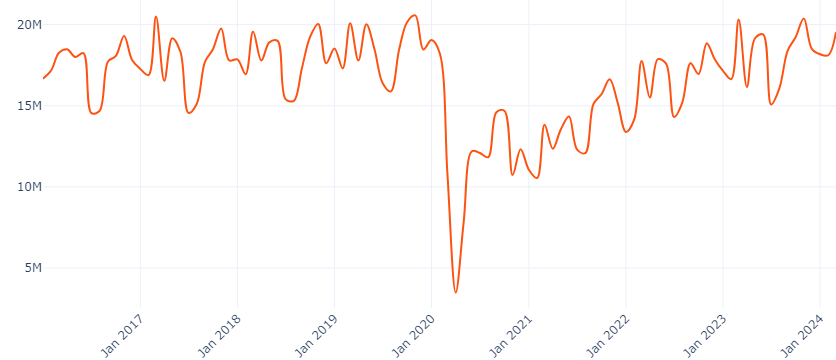

In [12]:
# Create a figure
fig = go.Figure()

# Add a line trace to the figure without markers
fig.add_trace(go.Scatter(
    x=total_montees_mensuelles['mois'], 
    y=total_montees_mensuelles['total_nb_de_montees'], 
    mode='lines', 
    line=dict(color='#FD5312', shape='spline'), 
    name='Montées',
    hovertemplate='<b>Montées: %{y:,.0f}</b><extra></extra>',  # Bold 'Montées''
    # hoverinfo='y'  # Show only y value on hover
))

# Update layout
fig.update_layout(
    xaxis=dict(
        tickformat='%b %Y',  # Customize date format
        tickangle=-45,  # Rotate tick labels by 45 degrees
    ),
    xaxis_fixedrange=False,
    yaxis_fixedrange=True,
    template='plotly_white',
    hoverlabel=dict(
        bgcolor='#FFFFFF',
        bordercolor='#FD5312',  # Orange border color
        font=dict(color='#000000')
    ),
    hovermode='x unified',
    margin=go.layout.Margin(l=0, r=0, b=0, t=0)
)


# Show the plot
fig.show()

# Plan des arrêts

## Column 1

### Plan des arrêts

In [24]:
def add_marker_to_map(row, marker_cluster):
    lon = row['coordonnees_lon']
    lat = row['coordonnees_lat']

    if not np.isnan(lon) and not np.isnan(lat):
        popup_html = "<b>Nom :</b> {}<br>".format(row['nom_arret'])
        popup_html += "<b>Commune :</b> {}<br>".format(row['commune'])
        popup_html += "<b>Pays :</b> {}<br>".format(row['pays'])
        popup_html += "<b>Code Arret :</b> {}<br>".format(row['arret_code_long'])

        if row['pays'] == 'CH':
            marker_color = 'red'
        else:
            marker_color = 'blue'

        folium.Marker(
            location=[lat, lon],
            tooltip=row['nom_arret'],
            icon=folium.Icon(color=marker_color, icon="bus", prefix="fa"),
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(marker_cluster)

def draw_map_arrets(coordonnees_centre, data_arrets_actifs, zoom_start=12):
    m = folium.Map(location=coordonnees_centre, zoom_start=zoom_start, min_zoom=9, control_scale=True, height='80%')
    marker_cluster = MarkerCluster(name='Arrêts').add_to(m)

    data_arrets_actifs.apply(add_marker_to_map, axis=1, marker_cluster=marker_cluster)

    return m

def geocode(address):
    headers = {
        'Referer': 'https://geneva-transports-analysis-c361239af243.herokuapp.com/'
    }
    params = { "q": address, 'format': 'json' }
    response = requests.get(f"https://nominatim.openstreetmap.org/search", params=params, headers=headers)
    if response.status_code == 200:
        places = response.json()
        if len(places) > 0:
            place = places[0]
            display_name = place['display_name']
            print(f'Adresse trouvée: {display_name}')
            return place

    print("Pas d'adresse trouvée")
    return None

def calculate_distance(stop_coords, selected_coords):
    return geodesic(stop_coords, selected_coords).meters

def get_closest_stops(data_arrets, selected_coords):

    # Compute distances for each stop
    data_arrets_with_distance = data_arrets.copy()
    data_arrets_with_distance['distance_to_selected'] = data_arrets_with_distance.apply(lambda row: calculate_distance((row['coordonnees_lat'], row['coordonnees_lon']), selected_coords), axis=1)

    # Sort the DataFrame based on computed distances and select top 10
    data_arrets_with_distance_sorted = data_arrets_with_distance.sort_values(by='distance_to_selected', ignore_index=True)[:10]

    # Keep useful columns
    data_arrets_with_distance_sorted = data_arrets_with_distance_sorted[['arret_code_long', 'nom_arret', 'distance_to_selected']]

    # Rename the columns
    data_arrets_with_distance_sorted.rename(columns={'arret_code_long': 'Code Arrêt', 'nom_arret': 'Arrêt', 'distance_to_selected': 'Distance (m)'}, inplace=True)

    # Round the distance column to 1 decimal place
    data_arrets_with_distance_sorted['Distance (m)'] = data_arrets_with_distance_sorted['Distance (m)'].round(1)
    
    return data_arrets_with_distance_sorted

def draw_map_arrets_with_search(event):
    searched_address = search_address_widget.value.strip()
    place = geocode(searched_address) if searched_address else None
    
    with out_table:
        clear_output()

    if place:
        coords = [place['lat'], place['lon']]
        closest_stops = get_closest_stops(data_arrets_actifs, coords)  
        zoom_start = 16
    else:
        coords = [data_arrets_actifs['coordonnees_lat'].mean(), data_arrets_actifs['coordonnees_lon'].mean()]
        closest_stops = None
        zoom_start = 12
        
    m = draw_map_arrets(coords, data_arrets_actifs, zoom_start=zoom_start)

    if place:
        folium.Marker(
            location=coords,
            tooltip=place['name'] if place['name'] else place['display_name'],
            popup=folium.Popup(place['display_name'], max_width=300)
        ).add_to(m)

    with out_map:
        clear_output(wait=True)
        if place:
            display(HTML(f"Adresse sélectionnée :\n  {place['name'] if place['name'] else place['display_name']}"))   
        display(m)
    
    with out_table:
        if closest_stops is not None:
            display(HTML(closest_stops.to_html(index=False)))


In [25]:
search_address_widget = widgets.Text(
    placeholder='Entrez l\'adresse choisie',
    description='Adresse:',
    disabled=False,
    layout=widgets.Layout(width='50%')
)

button = widgets.Button(description="Rechercher")

button.on_click(draw_map_arrets_with_search)
search_address_widget.on_submit(draw_map_arrets_with_search)

out_map = widgets.Output()
out_table = widgets.Output()

search_box = widgets.HBox([search_address_widget, button])
display(search_box)
display(out_map)

draw_map_arrets_with_search(None)

Output()

## Column 2

### Arrêts les plus proches

In [17]:
out_table

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<IPython.core.display.HTML object>', '…